Packages for data analysis and K-Means Clustering

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

# Continuing generated data analysis in clustering

Quick view of the data and features:

In [104]:
# Load the data
df = pd.read_csv('customer_data.csv')

# Print the first few rows of the DataFrame to check
df.head()

,Customer_ID,Company_Name,Industry,Segment,Company_Revenue,ARR,Contract_Value,Product_Features_Used,Usage_Frequency,Data_Usage,License_Count,Last_Activity_Date,Engagement_Score,NPS_Score,Support_Requests,Average_Response_Time,Resolution_Time,Health_Score,Churn_Risk_Score,Renewal_Date,CSAT_Score,Customer_Feedback,Upsell_Opportunity,Referral_Count,Custom_Features,API_Calls,Churned,CSM,Days_since_last_activity,Contract_Start_Date,Contract_length
0,1,Company_1,Finance,Strategic,3250225,11625,8026,3,Daily,8,11,2021-01-07,46.0,-24,1,7,15.000000,89.0,40,2025-02-21,73,Negative,False,0,1,11,False,CSM_Str_7,724,2023-07-20,582
1,2,Company_2,Manufacturing,Emerging,56394,10024,4944,4,Daily,6,12,2021-01-04,6.0,-2,3,16,26.655918,23.0,42,2020-01-01,2,Neutral,False,2,0,10,True,CSM_Eme_17,727,2018-11-12,415
2,3,Company_3,Education,Mid-Market,3654,11088,553,0,Monthly,11,13,2021-01-02,34.5,-94,7,12,38.793407,30.0,94,2020-01-02,85,Positive,False,2,0,11,True,CSM_Mid_2,729,2019-03-23,285
3,4,Company_4,Manufacturing,Enterprise,341292,486,10925,2,Weekly,8,5,2021-01-03,81.0,-15,1,13,14.000000,84.0,53,2024-07-07,26,Positive,False,0,0,10,False,CSM_Ent_6,728,2023-11-26,224
4,5,Company_5,Manufacturing,Mid-Market,177870,570,12471,7,Weekly,3,9,2021-01-02,37.0,-47,0,14,17.000000,63.0,63,2042-03-31,68,Negative,False,1,2,9,False,CSM_Mid_7,729,2041-06-27,277


If we want to use categorical variables we have to dummify them first, as well as scale the numerical ones.

In [105]:
# Define a transformer that only scales continuous variables and onehotencodes categorical variables
ct = ColumnTransformer([
    ("scale", StandardScaler(), ['ARR', 'Company_Revenue', 'Engagement_Score']),  # Scaling continuous features
    ("onehot", OneHotEncoder(), ['Usage_Frequency'])  # Encoding categorical feature
], remainder='drop')

# Fit and transform the features
features_transformed = ct.fit_transform(df)



In [106]:
features_transformed

array([[-0.36830327,  4.81060309,  0.01178987,  1.        ,  0.        ,
         0.        ],
       [-0.42598392, -0.68321462, -1.39700701,  1.        ,  0.        ,
         0.        ],
       [-0.38765025, -0.77393449, -0.39323923,  0.        ,  1.        ,
         0.        ],
       ...,
       [-0.75419799, -0.18266246, -0.79826834,  0.        ,  1.        ,
         0.        ],
       [-0.75297304, -0.67123388, -0.93914802,  0.        ,  0.        ,
         1.        ],
       [ 0.41007927,  0.1721754 , -0.92153806,  1.        ,  0.        ,
         0.        ]])

There is a clear kink in the line at 4, and it is in line with what we currently know (4 segments) and it tapers off, so for now we will use 4 clusters.

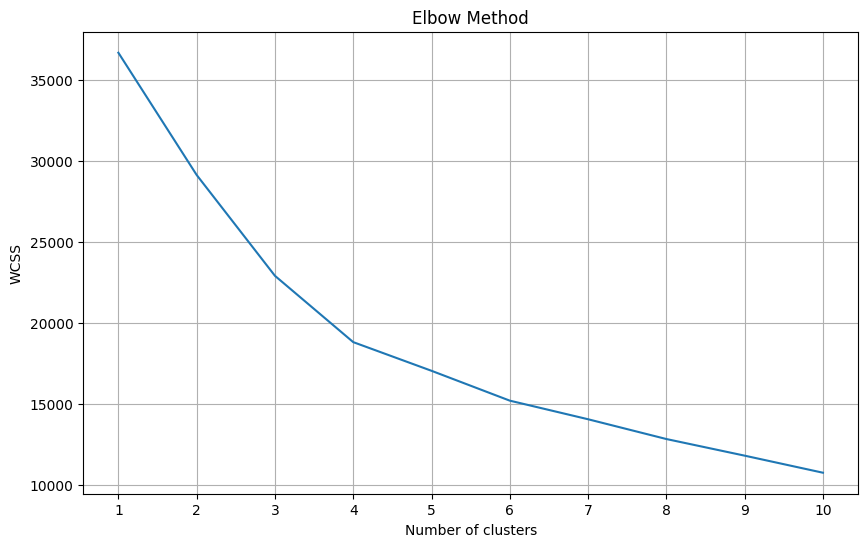

In [107]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features_transformed)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

Below is a quick google image of selecting optimal amount of clusters with this elbow method. WCSS scores are typically relative to the case being used, so visual selecting of clusters by kinks in line is generally accepted.

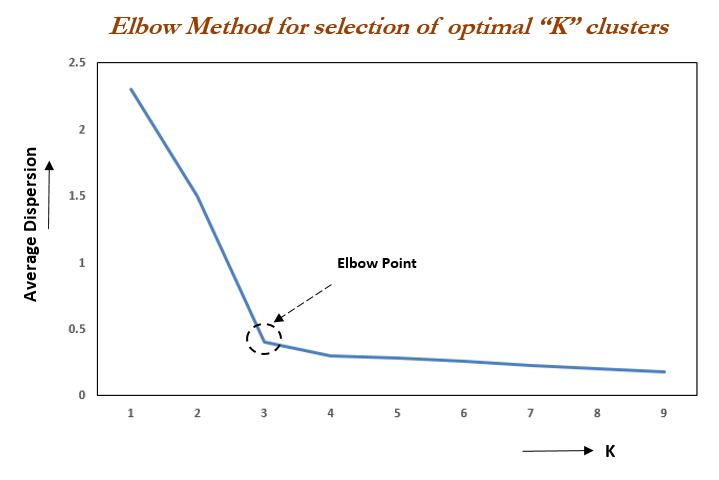

In [108]:
from IPython.display import Image
Image(filename='optimal_elbow.png')


Apply K-Means in this case to assign our clusters

In [109]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_transformed)

# Output the cluster assignments
print("Cluster assignments:", clusters)


Cluster assignments: [0 2 2 ... 2 2 2]


Just to ensure our clusters kept shape with our dataframe and we didn't run into a hidden error

In [110]:
clusters.shape

(10000,)

In [111]:
df.shape

(10000, 31)

Add clusters back to our original DataFrame

In [112]:
df['Cluster'] = clusters

Quick view of behind the scenes in what is going on, ARR, Revenue, Engagement Scores and Usage Frequency are being taken into account when separating clusters of companies. Clear separation of clusters 0 and 3. Clusters 1 and 2 very similar in ARR vs. Rev

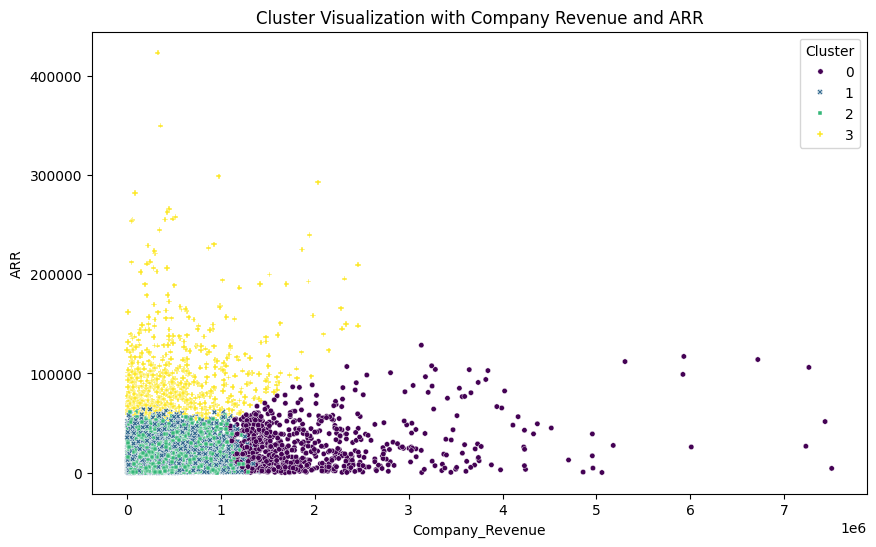

In [133]:
# Plot the clusters against variables
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Company_Revenue', y='ARR', hue='Cluster', data=df, palette='viridis', style='Cluster', s=15)
plt.title('Cluster Visualization with Company Revenue and ARR')
plt.show()


Below I wanted to put into perspective how clustering changes the preconceived dynamic of segmentation. Just by adding a few variables, the segments that we saw previously are drastically shaken up:

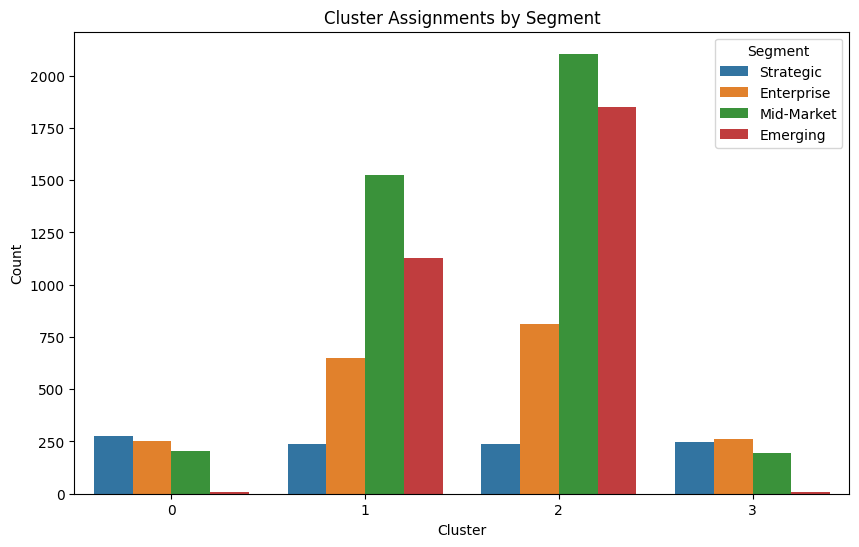

In [114]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Segment', data=df)
plt.title('Cluster Assignments by Segment')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Below we can see, in terms of ARR output, 2 and 1 are similar, 0 slightly higher ARR overall, and 3 takes the most

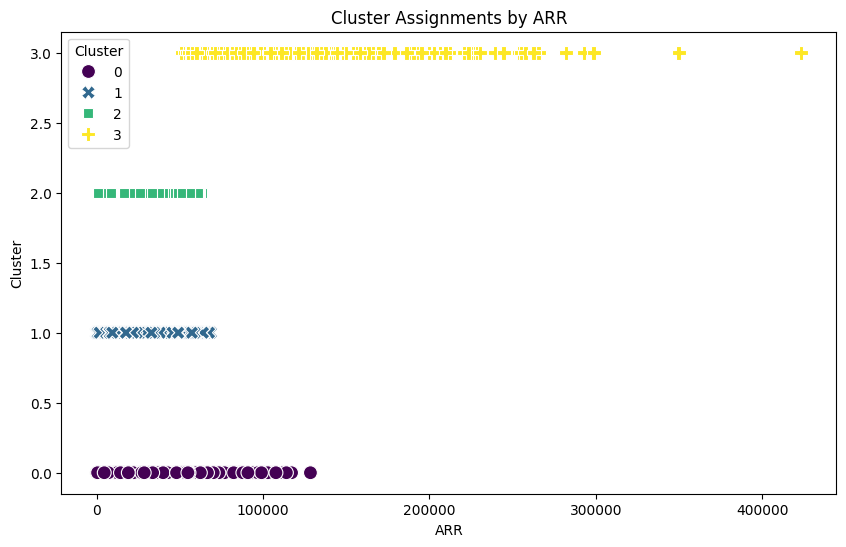

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ARR', y='Cluster', data=df, palette='viridis', hue='Cluster', style='Cluster', s=100)
plt.title('Cluster Assignments by ARR')
plt.xlabel('ARR')
plt.ylabel('Cluster')
plt.show()


ARR by mean in cluster: If a cluster like this is to emerge, we would want to know why and how to replicate these kinds of company contract / situations. As well as dedicate resources accordingly to high ARR segments

Cluster
0    27513.207268
1    15850.818079
2    14620.874875
3    96323.282913
Name: ARR, dtype: float64


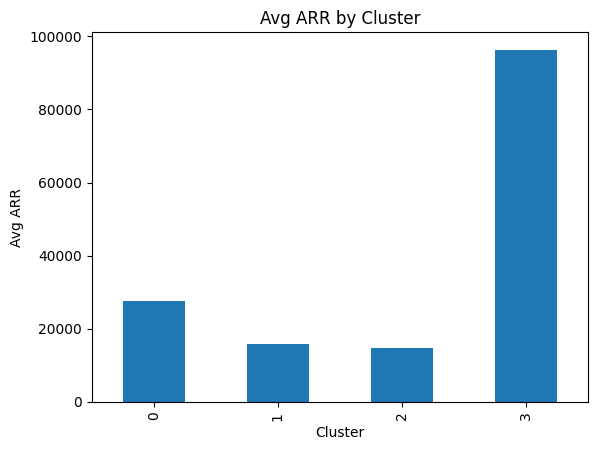

In [134]:
ARR_by_cluster = df.groupby('Cluster')['ARR'].mean()
ARR_by_cluster = ARR_by_cluster.reindex([0,1,2,3])
print(ARR_by_cluster)
ARR_by_cluster.plot(kind='bar')

plt.xlabel('Cluster')
plt.ylabel('Avg ARR')
plt.title('Avg ARR by Cluster')
plt.show()

One would think ARR and revenue would be closer aligned in cluster assignment. This not only goes against what we previously thought, it opens the door to more efficient resource allocation.

### AS WELL AS POTENTIAL UPSELL, maybe we aren't interacting with higher revenue companies the correct way. Can we look at similar revenue companies from clusters 3 and 0 to see similarities and differences outside of revenue and ARR to find upsells?

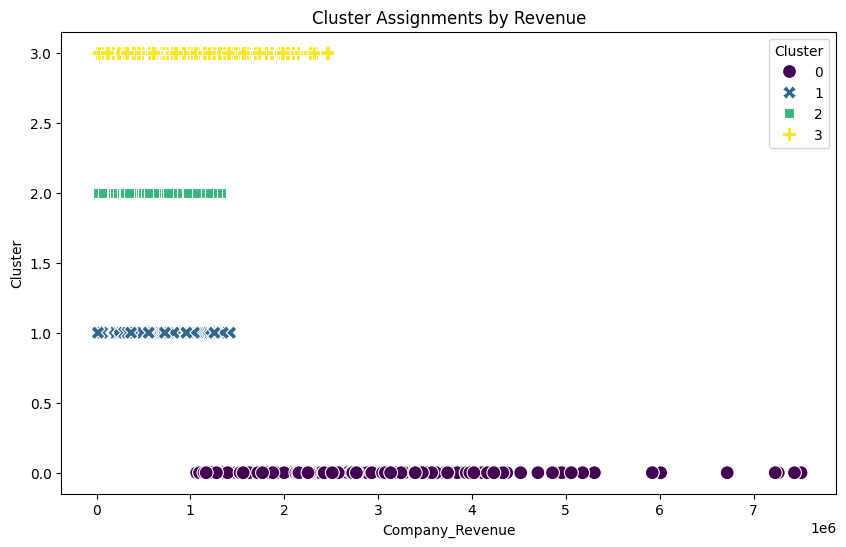

In [137]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Company_Revenue', y='Cluster', data=df, palette='viridis', hue='Cluster', style='Cluster', s=100)
plt.title('Cluster Assignments by Revenue')
plt.xlabel('Company_Revenue')
plt.ylabel('Cluster')
plt.show()

Cluster
0    1.979133e+06
1    3.407496e+05
2    2.977414e+05
3    5.174494e+05
Name: Company_Revenue, dtype: float64


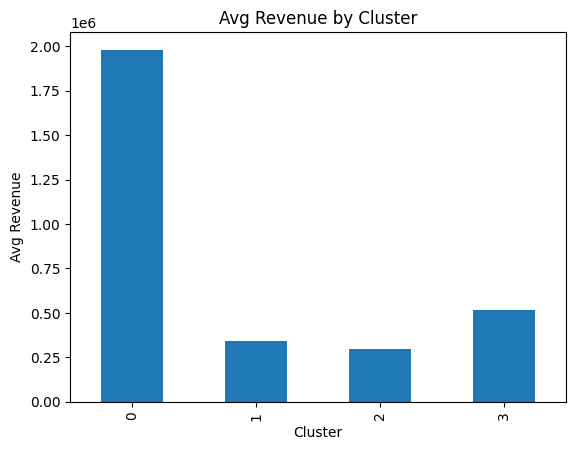

In [136]:
revenue_by_cluster = df.groupby('Cluster')['Company_Revenue'].mean()
revenue_by_cluster = revenue_by_cluster.reindex([0,1,2,3])
print(revenue_by_cluster)
revenue_by_cluster.plot(kind='bar')

plt.xlabel('Cluster')
plt.ylabel('Avg Revenue')
plt.title('Avg Revenue by Cluster')
plt.show()

Interesting that cluster 1 has high average engagement scores but also low revenue & low arr. Potentially small teams with a deep interest in product? Opportunities for higher avg ARR than avg revenue, content champions (blog posts, articles, use case name-dropping)

Cluster 2 has shown low average engagement scores, ARR, and revenue. If we are dedicating as many resources to that cluster as the rest we may be inefficient in our processes.

Cluster
0    45.253028
1    75.276836
2    24.730162
3    45.972689
Name: Engagement_Score, dtype: float64


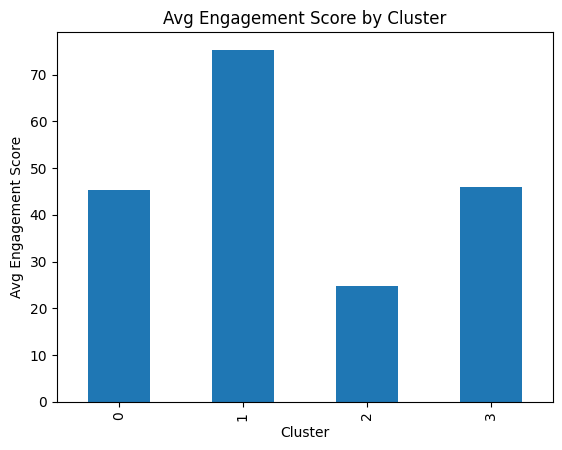

In [138]:
Engagement_by_cluster = df.groupby('Cluster')['Engagement_Score'].mean()
Engagement_by_cluster = Engagement_by_cluster.reindex([0,1,2,3])
print(Engagement_by_cluster)
Engagement_by_cluster.plot(kind='bar')

plt.xlabel('Cluster')
plt.ylabel('Avg Engagement Score')
plt.title('Avg Engagement Score by Cluster')
plt.show()

Pretty interesting even with our artificial data.. There seems to be new clusters that are segmented by ARR which could be due to the random nature of assigning values to ARR/Revenue. However, shows a promising ideal that company revenue may not be explicity tied to ARR, and may behave differently when we think about resource allocation. A company that has a high revenue may not be contributing the higher ends of ARR, and may be slower to move the needle on. Vice versa could apply as well, with real data it would be more interesting to digest.